In [1]:
#!/usr/bin/python
#dbr 01/22/25
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#read in dfs
dfall=pd.read_csv('data/wideout.csv')#,index=False)
dfpre=pd.read_csv('data/wideout-pre1yr.csv')#,index=False)
dfpost=pd.read_csv('data/wideout-post1yr.csv')#,index=False)


In [3]:
#models, take plist which are different lengths

def onephase(t,plist):
    y0,th = plist
    y = y0*np.exp(-th*t)
    return y

def twophase(t,plist):
    y01,th1,th2,tchg = plist
    y02 = y01*np.exp((-th1+th2)*tchg)
    y = y01*np.exp(-th1*t)+y02*np.exp(-th2*t)
    return y 

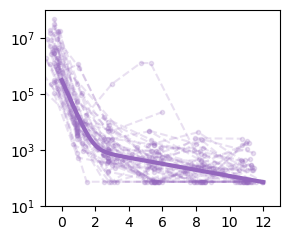

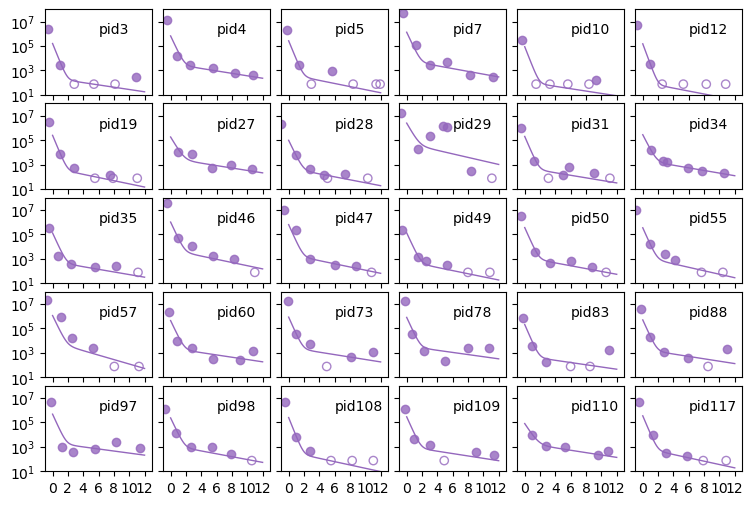

In [5]:
#viral load <1 year, do this separately because 2 phase model

#initialize
df=dfpre
cz='tab:purple'
ylimz=[10,1e8]
xlimz=[-1,13]
mname='splitV<1'
obsname='log10VL'

nt=5 #number of examples to show nt is longitudinal time points
param_df=pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

#plot
plt.figure(figsize=(3,2.5))

#data
for ip,pid in enumerate(df['short_id'].unique()):
    tdf = df[df['short_id']==pid][['time_ART_mo',obsname]].dropna()
    plt.plot(tdf['time_ART_mo'],10**tdf[obsname],marker='.',label='VL',color=cz,ls='--',alpha=0.2)

#simulation
tsim1=np.linspace(0,12,100)
popparamz=pd.read_csv('monolix/'+mname+'/populationParameters.txt')
V01,thV1,thV2,tchg = popparamz['value'].iloc[:4] #the population model parameters
V = twophase(tsim1,(V01,thV1,thV2,tchg))
plt.plot(tsim1,V,color=cz,lw=3) #simulated pop model

#plt.fill_between(simt1,np.exp(mem_results[4]+mem_results[1]*simt1),np.exp(mem_results[5]+mem_results[2]*simt1),color=cz,alpha=0.5,lw=1)
plt.semilogy()
plt.ylim(ylimz)
plt.xlim(xlimz)
#plt.xlabel('Time (months after ART)')
#plt.ylabel('Viral load \n' + r'log$_{10}$(copies/mL)')
plt.xticks(np.arange(0,13,2))

plt.tight_layout()    
plt.savefig('figures/Model-VL1.pdf',dpi=600)

#### now individual fits
fig,axs=plt.subplots(5,6,figsize=(9,6),sharex=True,sharey=True)
ii=0
for ip,pid in enumerate(df['short_id'].unique()):
    tdf = df[df['short_id']==pid]
    
    tdf1=tdf[tdf['cens_vl']==0]
    tdf2=tdf[tdf['cens_vl']==1]
    if len(tdf)>nt:
        ax=axs[int(ii/6)][ii%6]
        ax.scatter(tdf2['time_ART_mo'],10**tdf2['log10VL'],marker='o',color='none', edgecolor=cz, alpha=0.8)
        ax.semilogy(tdf1['time_ART_mo'],10**tdf1['log10VL'],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)
        
        #simulated individual
        tdfp = param_df[param_df['id']==pid]
        V01,thV1,thV2,tchg = tdfp[['V1_0_mode', 'thV1_mode', 'thV2_mode', 'tchg_mode']].values[0]
        V = twophase(tsim1,(V01,thV1,thV2,tchg))
        ax.plot(tsim1,V,color=cz,lw=1)
        ax.annotate('pid'+str(int(pid)),[6,1e6])

        ii+=1 #another index for plots

plt.ylim(ylimz)
plt.xlim(xlimz)
plt.xticks(np.arange(0,13,2))
plt.yticks([10,1e3,1e5,1e7])
plt.subplots_adjust(hspace=0.1,wspace=0.1)

plt.savefig('figures/Model-VL1-examples.pdf',dpi=600)


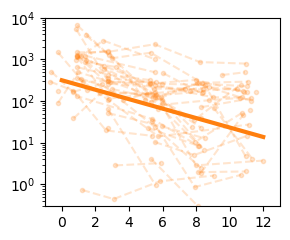

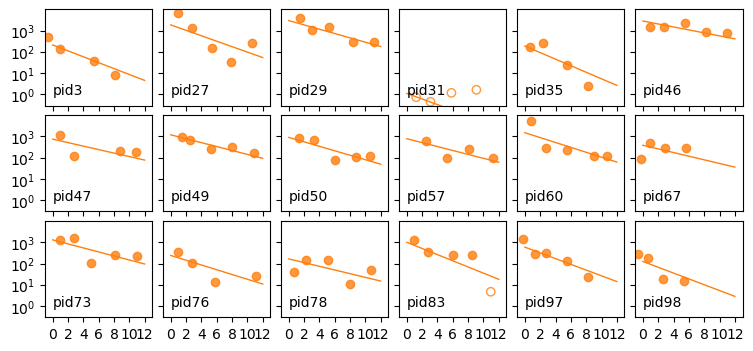

In [6]:
#now intact <1

mname = 'splitI<1'
obsname = 'log10int'

#initialize
df=dfpre
cz='tab:orange'
ylimz=[0.3,1e4]
xlimz=[-1,13]

nt=3 #number of examples to show nt is longitudinal time points
param_df=pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

#plot
plt.figure(figsize=(3,2.5))

#data
for ip,pid in enumerate(df['short_id'].unique()):
    tdf = df[df['short_id']==pid][['time_ART_mo',obsname]].dropna()
    plt.plot(tdf['time_ART_mo'],10**tdf[obsname],marker='.',color=cz,ls='--',alpha=0.2)

#simulation
tsim1=np.linspace(0,12,100)
popparamz=pd.read_csv('monolix/'+mname+'/populationParameters.txt')
y01,th1 = popparamz['value'].iloc[:2] #the population model parameters
ysim1 = onephase(tsim1,(y01,th1))
plt.semilogy(tsim1,ysim1,color=cz,lw=3) #simulated pop model
plt.ylim(ylimz)
plt.xlim(xlimz)
plt.xticks(np.arange(0,13,2))

plt.tight_layout()    
plt.savefig('figures/Model-'+obsname+'.pdf',dpi=600)

#### now individual fits
fig,axs=plt.subplots(3,6,figsize=(9,4),sharex=True,sharey=True)
ii=0
for ip,pid in enumerate(df['short_id'].unique()):
    tdf = df[df['short_id']==pid]
    
    tdf1=tdf[tdf['cens_intact']==0]
    tdf2=tdf[tdf['cens_intact']==1]
    if len(tdf[obsname].dropna())>nt:
        ax=axs[int(ii/6)][ii%6]
        ax.scatter(tdf2['time_ART_mo'],10**tdf2[obsname],marker='o',color='none', edgecolor=cz, alpha=0.8)
        ax.semilogy(tdf1['time_ART_mo'],10**tdf1[obsname],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)
        
        #simulated individual
        tdfp = param_df[param_df['id']==pid]
        y01,th1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
        ysim1 = onephase(tsim1,(y01,th1))
        ax.plot(tsim1,ysim1,color=cz,lw=1)
        ax.annotate('pid'+str(int(pid)),[0,1])

        ii+=1 #another index for plots

plt.yticks([1,10,100,1000])
plt.ylim(ylimz)
plt.xlim(xlimz)
plt.xticks(np.arange(0,13,2))
plt.subplots_adjust(hspace=0.1,wspace=0.1)

plt.savefig('figures/Model-'+obsname+'-examples.pdf',dpi=600)


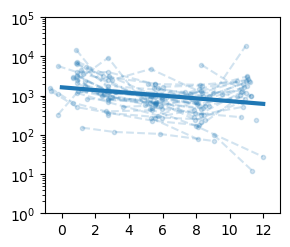

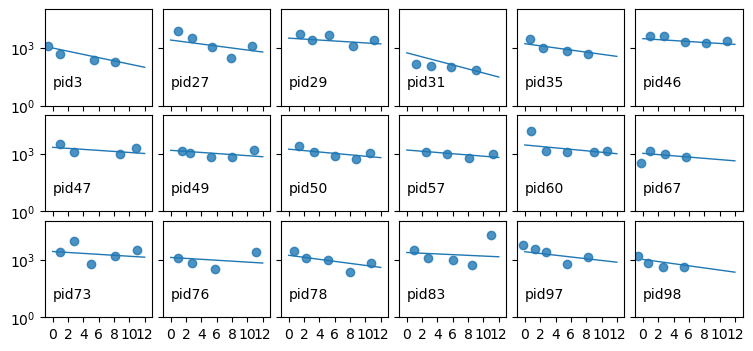

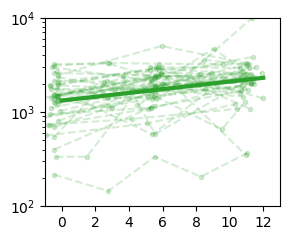

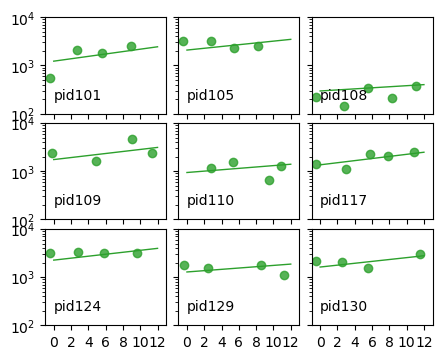

In [7]:
#now S and D <1 (together because no censoring)

df=dfpre
xlimz=[-1,13]
tsim1=np.linspace(0,12,100)

nt=3 #number of examples to show nt is longitudinal time points

for io in range(2):
    mname = ['splitD<1','splitS<1'][io]
    obsname = ['log10def','log10CD4'][io]

    #initialize
    cz=['tab:blue','tab:green'][io]
    ylimz=[[1,1e5],[100,1e4]][io]

    param_df=pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

    #plot
    plt.figure(figsize=(3,2.5))

    #data
    for ip,pid in enumerate(df['short_id'].unique()):
        tdf = df[df['short_id']==pid][['time_ART_mo',obsname]].dropna()
        plt.plot(tdf['time_ART_mo'],10**tdf[obsname],marker='.',color=cz,ls='--',alpha=0.2)

    #simulation
    popparamz=pd.read_csv('monolix/'+mname+'/populationParameters.txt')
    y01,th1 = popparamz['value'].iloc[:2] #the population model parameters
    ysim1 = onephase(tsim1,(y01,th1))
    plt.plot(tsim1,ysim1,color=cz,lw=3) #simulated pop model (NON LOG for CD4)
    #if io==0:
    plt.semilogy() #simulated pop model
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(0,13,2))

    plt.tight_layout()    
    plt.savefig('figures/Model-'+obsname+'.pdf',dpi=600)

    #### now individual fits
    if io==0:
        fig,axs=plt.subplots(3,6,figsize=(9,4),sharex=True,sharey=True)
    else:
        fig,axs=plt.subplots(3,3,figsize=(5,4),sharex=True,sharey=True)
        
    ii=0
    for ip,pid in enumerate(df['short_id'].unique()):
        tdf1 = df[df['short_id']==pid]
        if len(tdf1[obsname].dropna())>nt:
            ax=axs[int(ii/axs.shape[1])][ii%axs.shape[1]]
            ax.plot(tdf1['time_ART_mo'],10**tdf1[obsname],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)

            #if io==0:
            plt.semilogy() #nonlog for CD4?

            #simulated individual
            tdfp = param_df[param_df['id']==pid]
            y01,th1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
            ysim1 = onephase(tsim1,(y01,th1))
            ax.plot(tsim1,ysim1,color=cz,lw=1)
            ax.annotate('pid'+str(int(pid)),[[0,10],[0,200]][io])

            ii+=1 #another index for plots

    #plt.yticks([1,10,100,1000])
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(0,13,2))
    plt.subplots_adjust(hspace=0.1,wspace=0.1)

    plt.savefig('figures/Model-'+obsname+'-examples.pdf',dpi=600)


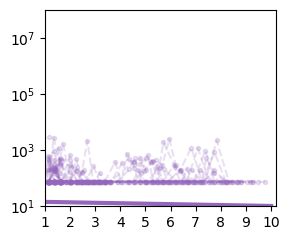

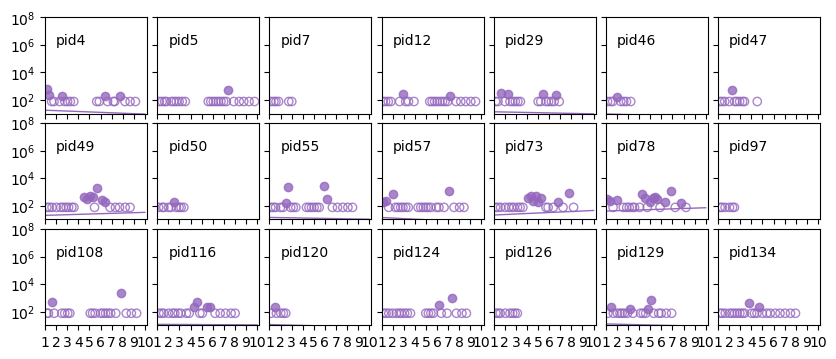

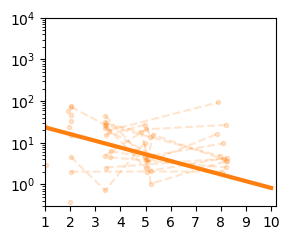

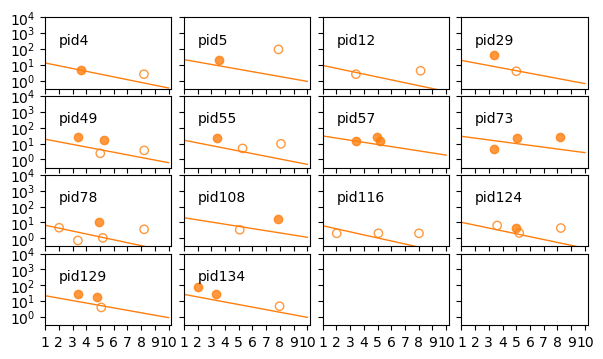

In [8]:
#now >1 year VL

df=dfpost
xlimz=[1,10.2] #in years
tsim1=np.linspace(12,120,100)

for io in range(2):
    mname = ['splitV>1','splitI>1'][io]
    obsname = ['log10VL','log10int'][io]
    censname= ['cens_vl','cens_intact'][io]

    nt=[5,1][io] #number of examples to show nt is longitudinal time points

    #initialize
    cz=['tab:purple','tab:orange'][io]
    ylimz=[[10,1e8],[0.3,1e4]][io]
    ytickz=[[1e2,1e4,1e6,1e8],[1,10,100,1e3,1e4]][io]

    param_df=pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

    #plot
    plt.figure(figsize=(3,2.5))

    #data
    for ip,pid in enumerate(df['short_id'].unique()):
        tdf = df[df['short_id']==pid][['time_ART_mo',obsname]].dropna()
        plt.plot(tdf['time_ART_mo']/12,10**tdf[obsname],marker='.',color=cz,ls='--',alpha=0.2)

    #simulation
    popparamz=pd.read_csv('monolix/'+mname+'/populationParameters.txt')
    y01,th1 = popparamz['value'].iloc[:2] #the population model parameters
    ysim1 = onephase(tsim1-tsim1[0],(y01,th1))
    plt.semilogy(tsim1/12,ysim1,color=cz,lw=3) #simulated pop model (NON LOG for CD4)
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(1,11,1))

    plt.tight_layout()    
    plt.savefig('figures/Model-'+obsname+'.pdf',dpi=600)

    #### now individual fits
    if io==0:
        fig,axs=plt.subplots(3,7,figsize=(10,4),sharex=True,sharey=True)
    else:
        fig,axs=plt.subplots(4,4,figsize=(7,4),sharex=True,sharey=True)
        
    ii=0
    for ip,pid in enumerate(df['short_id'].unique()):
        
        tdf = df[df['short_id']==pid]
        
        #add censoring
        tdf1=tdf[tdf[censname]==0]
        tdf2=tdf[tdf[censname]==1]

        if len(tdf[obsname].dropna())>nt:
            ax=axs[int(ii/axs.shape[1])][ii%axs.shape[1]]
            ax.scatter(tdf2['time_ART_mo']/12,10**tdf2[obsname],marker='o',color='none', edgecolor=cz, alpha=0.8)
            ax.plot(tdf1['time_ART_mo']/12,10**tdf1[obsname],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)

            #if io==0:
            plt.semilogy() #nonlog for CD4?

            #simulated individual
            tdfp = param_df[param_df['id']==pid]
            y01,th1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
            ysim1 = onephase(tsim1,(y01,th1))
            ax.plot(tsim1/12,ysim1,color=cz,lw=1)
            ax.annotate('pid'+str(int(pid)),[[2,1e6],[2,200]][io])

            ii+=1 #another index for plots

    plt.yticks(ytickz)
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(1,11,1))
    plt.subplots_adjust(hspace=0.1,wspace=0.1)

    plt.savefig('figures/Model-'+obsname+'-examples.pdf',dpi=600)


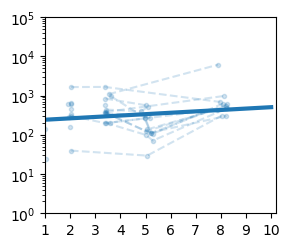

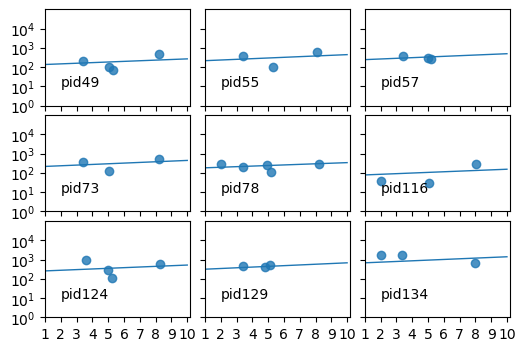

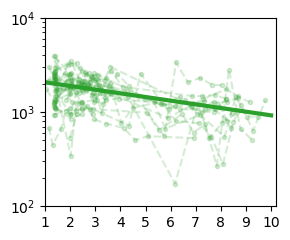

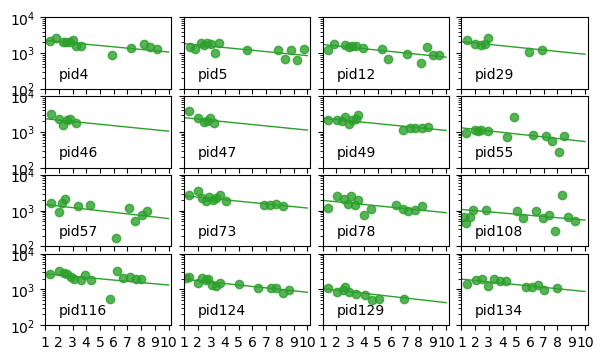

In [9]:
#now >1 year

df=dfpost
xlimz=[1,10.2] #in years
tsim1=np.linspace(12,120,100)

for io in range(2):
    mname = ['splitD>1','splitS>1'][io]
    obsname = ['log10def','log10CD4'][io]

    nt=[2,5][io] #number of examples to show nt is longitudinal time points

    #initialize
    cz=['tab:blue','tab:green'][io]
    ylimz=[[1,1e5],[100,1e4]][io]

    param_df=pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')

    #plot
    plt.figure(figsize=(3,2.5))

    #data
    for ip,pid in enumerate(df['short_id'].unique()):
        tdf = df[df['short_id']==pid][['time_ART_mo',obsname]].dropna()
        plt.plot(tdf['time_ART_mo']/12,10**tdf[obsname],marker='.',color=cz,ls='--',alpha=0.2)

    #simulation
    popparamz=pd.read_csv('monolix/'+mname+'/populationParameters.txt')
    y01,th1 = popparamz['value'].iloc[:2] #the population model parameters
    ysim1 = onephase(tsim1-tsim1[0],(y01,th1))
    plt.plot(tsim1/12,ysim1,color=cz,lw=3) #simulated pop model (NON LOG for CD4)
    #if io==0:
    plt.semilogy() #simulated pop model
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(1,11,1))

    plt.tight_layout()    
    plt.savefig('figures/Model-'+obsname+'.pdf',dpi=600)

    #### now individual fits
    if io==0:
        fig,axs=plt.subplots(3,3,figsize=(6,4),sharex=True,sharey=True)
    else:
        fig,axs=plt.subplots(4,4,figsize=(7,4),sharex=True,sharey=True)
        
    ii=0
    for ip,pid in enumerate(df['short_id'].unique()):
        tdf1 = df[df['short_id']==pid]

        if len(tdf1[obsname].dropna())>nt:
            ax=axs[int(ii/axs.shape[1])][ii%axs.shape[1]]
            ax.plot(tdf1['time_ART_mo']/12,10**tdf1[obsname],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)

            #if io==0:
            plt.semilogy() #nonlog for CD4?

            #simulated individual
            tdfp = param_df[param_df['id']==pid]
            y01,th1 = tdfp[['V1_0_mode', 'thV1_mode']].values[0]
            ysim1 = onephase(tsim1,(y01,th1))
            ax.plot(tsim1/12,ysim1,color=cz,lw=1)
            ax.annotate('pid'+str(int(pid)),[[2,10],[2,200]][io])

            ii+=1 #another index for plots

    plt.yticks([1,10,100,1e3,1e4])
    plt.ylim(ylimz)
    plt.xlim(xlimz)
    plt.xticks(np.arange(1,11,1)) #in years
    plt.subplots_adjust(hspace=0.1,wspace=0.1)

    plt.savefig('figures/Model-'+obsname+'-examples.pdf',dpi=600)
